In [1]:
import numpy as np
import matplotlib.pyplot as plt

import config
# GPU에서 실행하려면 아래 주석을 해제하세요(CuPy 필요).
# ===============================================
config.GPU = True
# ===============================================
import pickle
from trainer import Trainer
from optimizer import Adam

from util import *
from dataset import ptb

------------------------------------------------------------
                       GPU Mode (cupy)
------------------------------------------------------------



# Chapter 4 word2vec 속도 개선

이번 장의 목표는 word2vec의 속도 개선이다. 
- Embedding 계층 도입
- 네거티브 샘플링이라는 새로운 loss function 도입
이후 PTB 데이터셋을 가지고 학습을 수행할 예정이다. 

## 4.1 word2vec 개선 1

어휘가 100만개가 있는 corpus를 이용할 때 CBOW 모델을 표현하면 다음 그림과 같다.

<img src="./deep_learning_2_images/fig 4-2.png" width="60%">

다음 계산을 할 때 병목들이 발생한다.
- 입력층의 one-hot vector와 가중치 행렬 $\mathbf{W}_{in}의 곱 계산$
  - 단어의 수가 늘어나면, one-hot vector의 크기가 매우 커진다.
  - Embedding 계층을 도입함으로써 해결한다.
- 은닉층과 가중치 행렬 $\mathbf{W}_{out}$의 곱 및 Softmax 계층의 계산
  - 네거티브 샘플링이라는 새로운 loss function을 도입해 해 해결한다.

### 4.1.1 Embedding 계층

<img src="./deep_learning_2_images/fig 4-3.png" width="60%">

위 그림에서 볼 수 있듯이, 입력층과 가중치 행렬 간의 행렬곱 결과는 가중치 행렬의 한 행벡터를 추출하는 것이다. 이 행벡터를 추출하는 계층을 Embedding 계층이라고 부른다.

### 4.1.2 Embedding 계층 구현

numpy에서 행렬의 특정 행벡터를 뽑아내는 일은 매우 간단하다. 이를 코드로 표현하면 다음과 같다.

In [2]:
"""
------------------------------------------------------------
Code Source:
Author: WegraLee
Repository: deep-learning-from-sratch-2
URL: https://github.com/WegraLee/deep-learning-from-scratch-2/blob/master/common/layers.py
License: MIT License
Accessed: 2024-11-20

Modified to work on jupyter notebook
------------------------------------------------------------
"""

class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None

    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out

    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0
        np.add.at(dW, self.idx, dout)
        return None

Embedding 계층의 역전파는 앞에서 전해진 기울기를 그대로 흘려보내면 된다.

<img src="./deep_learning_2_images/fig 4-4.png" width="60%">

이때, idx가 중복되는 상황이 발생하면, 이전에 저장한 값을 덮어씌우는 문제가 발생한다. 이를 해결하기 위해, idx에 해당하는 기울기들을 더해나간다.

<img src="./deep_learning_2_images/fig 4-5.png" width="60%">

## 4.2 word2vec 개선 2

네거티브 샘플링을 이용해 두 번째 병목 현상을 해결할 것이다. 

### 4.2.1 은닉층 이후 계산의 문제점

은닉층 이후 계산이 오래 걸리는 부분은 다음 두 부분이다.
- 은닉층 뉴런과 가중치 행렬($\mathbf{W}_{out}$)의 곱
- Softmax 계층의 계산

첫 번째 계산은 거대한 행렬들끼리 곱셈을 수행하는 것이 문제이므로 행렬곱을 '가볍게' 만들어야 한다.
두 번째 계산은 Softmax를 대신할 '가벼운' 계산이 필요하다.

### 4.2.2 다중 분류에서 이진 분류로

네거티브 샘플링을 이해하는 데 가장 중요한 포인트가 "다중 분류를 이진 분류로 근사할 수 없을까?"이다.

신경망이 답해야 하는 질문을 바꿔보는 것이다. 예를 들어, "context가 'you'와 'goodbye'일 때, target 단어는 무엇인가?" 라는 질문을 "context가 'you'와 'goodbye'일 때, target 단어가 'say'인가?"와 같은 질문으로 바꿔야 한다.

즉, 다음 그림과 같이 CBOW 모델의 출력을 바꿀 수 있다.

<img src="./deep_learning_2_images/fig 4-7.png" width="60%">

저 확률은 출력층의 가중치 행렬에서 "say"에 해당하는 단어 벡터를 추출한 다음, 추출된 벡터와 은닉층 뉴런 사이의 내적을 계산하면 구할 수 있다.

<img src="./deep_learning_2_images/fig 4-8.png" width="60%">

### 4.2.3 시그모이드 함수와 교차 엔트로피 오차

이진 분류의 경우 시그모이드 함수와 cross-entropy loss의 조합을 사용한다.

시그모이드 함수는 다음과 같다.

$$
y = \frac{1}{1+\exp(-x)}
$$

시그모이드 함수를 cross-entropy loss에 적용하면 다음과 같은 식이 나온다.

$$
L = -(t\log y + (1-t) \log (1-y))
$$

$y$는 시그모이드 함수의 출력, $t$는 정답 레이블이다. $t$가 1이면 Yes, $t$가 0이면 No이다.

Sigmoid 계층과 Cross Entropy Error 계층의 역전파 값은 $y-t$이다.

### 4.2.4 다중 분류에서 이진 분류로(구현)

이때까지 이야기 한 점을 신경망 구성 그림으로 나타내면 다음과 같다. 

<img src="./deep_learning_2_images/fig 4-12.png" width="60%">

후반부 Embedding 계층과 내적을 합쳐서 EmbeddingDot 계층을 만들 수 있다. 

<img src="./deep_learning_2_images/fig 4-13.png" width="60%">

Embedding Dot 계층은 다음과 같이 구현할 수 있다.

In [3]:
"""
------------------------------------------------------------
Code Source:
Author: WegraLee
Repository: deep-learning-from-sratch-2
URL: https://github.com/WegraLee/deep-learning-from-scratch-2/blob/master/ch04/negative_sampling_layer.py
License: MIT License
Accessed: 2024-11-20

Modified to work on jupyter notebook
------------------------------------------------------------
"""


class EmbeddingDot:
    def __init__(self, W):
        self.embed = Embedding(W)
        self.params = self.embed.params
        self.grads = self.embed.grads
        self.cache = None

    def forward(self, h, idx):
        # Embedding 계층을 이용해 열벡터를 뽑아온다.
        target_W = self.embed.forward(idx)
        # 내적 수행
        out = np.sum(target_W * h, axis=1)

        self.cache = (h, target_W)
        return out

    def backward(self, dout):
        h, target_W = self.cache
        dout = dout.reshape(dout.shape[0], 1)

        dtarget_W = dout * h
        self.embed.backward(dtarget_W)
        dh = dout * target_W
        return dh

역전파는 스스로 생각해보라고 해서, 이렇게 생각해봤다.

<img src="./img/memo-4-2-4-embeddingdot-backward.jpg" width="60%">

### 4.2.5 네거티브 샘플링

지금까지 우리는 이진 분류 중에서 Yes를 뽑아내도록 학습했다. No에 대한 정보도 같이 학습해야 정확하고, 이런 결과를 만들어내는 가중치 또한 있어야 한다. 하지만 모든 No에 대한 정보를 학습하면 학습해야 할 어휘의 수가 굉장히 많이 늘어나기 때문에, 부정적 예를 몇가지만 샘플링해서 학습해야 한다. 이것이 '네거티브 샘플링' 기법이다. 

좀 더 정확한 설명을 하면, Yes에 대해서 학습을 하면서 No에 대한 단어들을 몇 개 뽑아서 같이 loss를 구한 다음, 그 loss들을 더한 값을 최종 loss로 삼는 것이다. 그림으로 그리면 다음과 같다.

<img src="./deep_learning_2_images/fig 4-17.png" width="60%">

### 4.2.6 네거티브 샘플링의 샘플링 기법

네거티브 샘플링에서 단어를 선택하는 방법은 corpus의 확률분포를 이용하는 방법이다. 확률분포대로 뽑으면 희소한 단어는 적게 선택된다.

word2vec의 네거티브 샘플링에서는 기본 확률분포에 0.75를 제곱해, 희소한 단어가 뽑힐 확률을 조금 올려준다.

$$
P'(w_i) = \frac{P(w_i)^{0.75}}{\sum_{j}^{n}P(w_j)^{0.75}}
$$

UnigramSampler를 책에서 제공한다. 구현 코드를 보고 공부해보자. 주석 처리로 나의 해석을 적어놨다

In [4]:
"""
------------------------------------------------------------
Code Source:
Author: WegraLee
Repository: deep-learning-from-sratch-2
URL: https://github.com/WegraLee/deep-learning-from-scratch-2/blob/master/ch04/negative_sampling_layer.py
License: MIT License
Accessed: 2024-11-20

Modified to work on jupyter notebook
------------------------------------------------------------
"""

import collections


class UnigramSampler:
    def __init__(self, corpus, power, sample_size):
        self.sample_size = sample_size
        self.vocab_size = None
        self.word_p = None

        # 각 단어의 개수를 세아린다.
        counts = collections.Counter()
        for word_id in corpus:
            counts[word_id] += 1

        # corpus 속 단어의 개수를 구한다.
        vocab_size = len(counts)
        self.vocab_size = vocab_size

        # 각 단어별 출현하는 확률을 구해 np.array 형태로 만든다.
        self.word_p = np.zeros(vocab_size)
        for i in range(vocab_size):
            self.word_p[i] = counts[i]

        self.word_p = np.power(self.word_p, power)
        self.word_p /= np.sum(self.word_p)

    def get_negative_sample(self, target):
        batch_size = target.shape[0]

        if not GPU:
            negative_sample = np.zeros((batch_size, self.sample_size), dtype=np.int32)

            for i in range(batch_size):
                # target에 해당하는 단어를 뽑지 않기 위해, target_idx에 해당하는 확률을 0으로 만든다.
                p = self.word_p.copy()
                target_idx = target[i]
                p[target_idx] = 0
                p /= p.sum()
                negative_sample[i, :] = np.random.choice(self.vocab_size, size=self.sample_size, replace=False, p=p)
        else:
            # GPU(cupy）로 계산할 때는 속도를 우선한다.
            # 부정적 예에 타깃이 포함될 수 있다.
            negative_sample = np.random.choice(self.vocab_size, size=(batch_size, self.sample_size),
                                               replace=True, p=self.word_p)

        return negative_sample

### 4.2.7 네거티브 샘플링 구현

In [5]:
"""
------------------------------------------------------------
Code Source:
Author: WegraLee
Repository: deep-learning-from-sratch-2
URL: https://github.com/WegraLee/deep-learning-from-scratch-2/blob/master/ch04/negative_sampling_layer.py
License: MIT License
Accessed: 2024-11-20

Modified to work on jupyter notebook
------------------------------------------------------------
"""

from layers import Embedding, SigmoidWithLoss

class NegativeSamplingLoss:
    def __init__(self, W, corpus, power=0.75, sample_size=5):
        self.sample_size = sample_size
        self.sampler = UnigramSampler(corpus, power, sample_size)

        # target과 negative sampling으로 뽑은 단어별로 sigmoid loss를 구해야 한다.
        self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size + 1)]

        # target과 negative sampling으로 뽑은 단어별로 점수를 뽑아내야 한다.
        self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)]

        self.params, self.grads = [], []
        for layer in self.embed_dot_layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, h, target):
        batch_size = target.shape[0]
        
        # negative sampling으로 단어들을 뽑는다.
        negative_sample = self.sampler.get_negative_sample(target)

        # 긍정적 예 순전파
        score = self.embed_dot_layers[0].forward(h, target)
        correct_label = np.ones(batch_size, dtype=np.int32)
        loss = self.loss_layers[0].forward(score, correct_label)

        # 부정적 예 순전파
        negative_label = np.zeros(batch_size, dtype=np.int32)
        for i in range(self.sample_size):
            negative_target = negative_sample[:, i]
            score = self.embed_dot_layers[1 + i].forward(h, negative_target)
            loss += self.loss_layers[1 + i].forward(score, negative_label)

        return loss

    def backward(self, dout=1):
        dh = 0
        for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
            dscore = l0.backward(dout)
            dh += l1.backward(dscore)

        return dh

역전파 설명은 다음 그림으로 설명할 수 있다.

<img src="./img/memo-4-2-7-negativesampling-backward.jpg" width="60%">

## 4.3 개선판 word2vec 학습

개선된 CBOW 모델의 모습은 다음과 같다.

In [6]:
"""
------------------------------------------------------------
Code Source:
Author: WegraLee
Repository: deep-learning-from-sratch-2
URL: https://github.com/WegraLee/deep-learning-from-scratch-2/blob/master/ch04/cbow.py
License: MIT License
Accessed: 2024-11-20

Modified to work on jupyter notebook
------------------------------------------------------------
"""


from layers import Embedding


class CBOW:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size

        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')

        # W_in과 W_out의 형상이 같은데, 이유는 W_out도 Embedding 계층을 사용하기 때문이다.
        W_out = 0.01 * np.random.randn(V, H).astype('f')

        # 계층 생성
        self.in_layers = []
        for i in range(2 * window_size):
            layer = Embedding(W_in)  # Embedding 계층 사용
            self.in_layers.append(layer)
        self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)

        # 모든 가중치와 기울기를 배열에 모은다.
        layers = self.in_layers + [self.ns_loss]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = 0
        for i, layer in enumerate(self.in_layers):
            h += layer.forward(contexts[:, i])
        h *= 1 / len(self.in_layers)
        loss = self.ns_loss.forward(h, target)
        return loss

    def backward(self, dout=1):
        dout = self.ns_loss.backward(dout)
        dout *= 1 / len(self.in_layers)
        for layer in self.in_layers:
            layer.backward(dout)
        return None

CUPY를 설치해보려고 하는데, python 3.9가 필요하다고 해서, 설치를 한 뒤에 학습을 돌려보자. GPU가 있어야 학습 결과를 볼 수 있을 거 같다.

In [7]:
"""
------------------------------------------------------------
Code Source:
Author: WegraLee
Repository: deep-learning-from-sratch-2
URL: https://github.com/WegraLee/deep-learning-from-scratch-2/blob/master/ch04/skip_gram.py
License: MIT License
Accessed: 2024-11-20

Modified to work on jupyter notebook
------------------------------------------------------------
"""

from layers import *


class SkipGram:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        W_in = 0.01 * rn(V, H).astype('f')
        W_out = 0.01 * rn(V, H).astype('f')

        # 계층 생성
        self.in_layer = Embedding(W_in)
        self.loss_layers = []
        for i in range(2 * window_size):
            layer = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)
            self.loss_layers.append(layer)

        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer] + self.loss_layers
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = self.in_layer.forward(target)

        loss = 0
        for i, layer in enumerate(self.loss_layers):
            loss += layer.forward(h, contexts[:, i])
        return loss

    def backward(self, dout=1):
        dh = 0
        for i, layer in enumerate(self.loss_layers):
            dh += layer.backward(dout)
        self.in_layer.backward(dh)
        return None

| 에폭 1 |  반복 1 / 9295 | 시간 0[s] | 손실 4.16
| 에폭 1 |  반복 21 / 9295 | 시간 0[s] | 손실 4.16
| 에폭 1 |  반복 41 / 9295 | 시간 0[s] | 손실 4.15
| 에폭 1 |  반복 61 / 9295 | 시간 1[s] | 손실 4.12
| 에폭 1 |  반복 81 / 9295 | 시간 1[s] | 손실 4.05
| 에폭 1 |  반복 101 / 9295 | 시간 1[s] | 손실 3.92
| 에폭 1 |  반복 121 / 9295 | 시간 1[s] | 손실 3.78
| 에폭 1 |  반복 141 / 9295 | 시간 1[s] | 손실 3.63
| 에폭 1 |  반복 161 / 9295 | 시간 1[s] | 손실 3.50
| 에폭 1 |  반복 181 / 9295 | 시간 1[s] | 손실 3.36
| 에폭 1 |  반복 201 / 9295 | 시간 1[s] | 손실 3.26
| 에폭 1 |  반복 221 / 9295 | 시간 1[s] | 손실 3.16
| 에폭 1 |  반복 241 / 9295 | 시간 2[s] | 손실 3.08
| 에폭 1 |  반복 261 / 9295 | 시간 2[s] | 손실 3.03
| 에폭 1 |  반복 281 / 9295 | 시간 2[s] | 손실 2.96
| 에폭 1 |  반복 301 / 9295 | 시간 2[s] | 손실 2.93
| 에폭 1 |  반복 321 / 9295 | 시간 2[s] | 손실 2.88
| 에폭 1 |  반복 341 / 9295 | 시간 2[s] | 손실 2.85
| 에폭 1 |  반복 361 / 9295 | 시간 2[s] | 손실 2.85
| 에폭 1 |  반복 381 / 9295 | 시간 2[s] | 손실 2.80
| 에폭 1 |  반복 401 / 9295 | 시간 2[s] | 손실 2.78
| 에폭 1 |  반복 421 / 9295 | 시간 3[s] | 손실 2.75
| 에폭 1 |  반복 441 / 9295 | 시간 3[s] | 손실

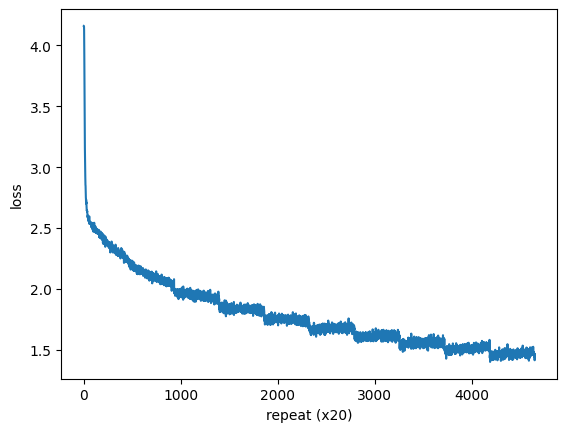

In [ ]:
"""
------------------------------------------------------------
Code Source:
Author: WegraLee
Repository: deep-learning-from-sratch-2
URL: https://github.com/WegraLee/deep-learning-from-scratch-2/blob/master/ch04/train.py
License: MIT License
Accessed: 2024-11-20

Modified to work on jupyter notebook
------------------------------------------------------------
"""

# 새 버전의 cupy를 이용한다면, np.py에서 np.add.at 부분을 지워야 한다.

# 하이퍼파라미터 설정
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

# 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)
if config.GPU:
    contexts, target = to_gpu(contexts), to_gpu(target)

# 모델 등 생성
model = CBOW(vocab_size, hidden_size, window_size, corpus)
# model = SkipGram(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

# 학습 시작
trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

# 나중에 사용할 수 있도록 필요한 데이터 저장
word_vecs = model.word_vecs
if config.GPU:
    word_vecs = to_cpu(word_vecs)
params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'cbow_params.pkl'  # or 'skipgram_params.pkl'
with open(pkl_file, 'wb') as f:
    pickle.dump(params, f, -1)

### 4.3.3 CBOW 모델 평가

In [11]:
"""
------------------------------------------------------------
Code Source:
Author: WegraLee
Repository: deep-learning-from-sratch-2
URL: https://github.com/WegraLee/deep-learning-from-scratch-2/blob/master/ch04/eval.py
License: MIT License
Accessed: 2024-11-20

Modified to work on jupyter notebook
------------------------------------------------------------
"""

import pickle


pkl_file = 'cbow_params.pkl'
# pkl_file = 'skipgram_params.pkl'

with open(pkl_file, 'rb') as f:
    params = pickle.load(f)
    word_vecs = params['word_vecs']
    word_to_id = params['word_to_id']
    id_to_word = params['id_to_word']

# 가장 비슷한(most similar) 단어 뽑기
querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)

# 유추(analogy) 작업
print('-'*50)
analogy('king', 'man', 'queen',  word_to_id, id_to_word, word_vecs)
analogy('take', 'took', 'go',  word_to_id, id_to_word, word_vecs)
analogy('car', 'cars', 'child',  word_to_id, id_to_word, word_vecs)
analogy('good', 'better', 'bad',  word_to_id, id_to_word, word_vecs)


[query] you


TypeError: Unsupported type <class 'numpy.ndarray'>

검증 내용은 실행이 안되면 그냥 나중에 확인하자

## 4.4 word2vec 남은 주제

### 4.4.1 word2vec을 사용한 애플리케이션의 예

자연어 처리 분야에서 단어의 분산 표현이 중요한 이유는 **전이 학습**에 있다. 미리 큰 말뭉치를 이용해 학습된 분산 표현을 이용해 다른 자연어 처리 작업에 사용한다.

단어의 분산 표현은 단어를 고정 길이 벡터로 변환해준다. 또한, 문장도 단어의 분산 표현을 이용해 고정 길이 벡터로 변환할 수 있다. 문장을 고정 길이 벡터로 표현하는 방법 중 하나는 bag-of-words이다. RNN을 이용하면 word2vec의 분산 표현을 이용해 문장을 고정 길이 벡터로 표현할 수 있다.

단어나 문장을 고정 길이 벡터로 표현할 수 있다면, 일반적인 머신러닝 기법을 이용할 수 있어서 중요하다.

<img src="./deep_learning_2_images/fig 4-21.png" width="60%">

### 4.4.2 단어 벡터 평가 방법

단어의 분산 표현이 좋은지를 평가하는 방법은 다양하다.

한 방법은 사람이 만든 유사도 검증 세트를 이용한 방법이다. 사람이 부여한 점수와 word2vec이 반환한 코사인 유사도 점수를 비교해 점수를 메기는 방법이다.

다른 방법은 유추 문제를 활용한 평가이다. 유추 문제를 잘 풀어내는지 여부를 가지고 모델을 평가하는 방법이다. 